In [1]:
import torch
import pytorch3d
from pytorch3d.structures import Meshes
import pytorch3d.renderer as rdr
from pytorch3d.io import load_objs_as_meshes
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tqdm.notebook import tqdm

In [2]:
def get_mesh_renderer(image_size=512):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    R, T = rdr.look_at_view_transform(2.7, 0, 0)
    cameras = rdr.FoVPerspectiveCameras(device=device, R=R, T=T)
    
    raster_set = rdr.RasterizationSettings(
        image_size=image_size, 
        blur_radius=0.0, 
        faces_per_pixel=1
    )
    
    lights = rdr.PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    
    render = rdr.MeshRenderer(
        rasterizer=rdr.MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_set
        ),
        shader=rdr.HardPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )
    )
    return render

In [3]:
def apply_color_gradient(mesh, color1, color2, device):
    verts = mesh.verts_packed()
    
    z_coords = verts[:, 2]
    
    z_min, z_max = z_coords.min(), z_coords.max()
    alpha = (z_coords - z_min) / (z_max - z_min)
    
    alpha = alpha.unsqueeze(-1)
    
    color1 = torch.tensor(color1, device=device)
    color2 = torch.tensor(color2, device=device)
    
    vertex_colors = alpha * color2 + (1 - alpha) * color1
    vertex_colors = vertex_colors.unsqueeze(0)
    
    textures = rdr.TexturesVertex(vertex_colors)
    
    color_mesh = Meshes(
        verts=mesh.verts_list(),
        faces=mesh.faces_list(),
        textures=textures
    )
    
    return color_mesh

In [4]:
def render_360_degree_mesh(mesh, device, image_size=512, num_views=72, distance=2.75, elevation=30):
    renderer = get_mesh_renderer(image_size=image_size)
    angles = torch.linspace(-180, 180, num_views)
    lights = rdr.PointLights(location=[[0, 0, -3]], device=device)
    images = []
    
    for angle in tqdm(angles):
        R, T = rdr.look_at_view_transform(dist=distance, elev=elevation, azim=angle)
        cameras = rdr.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        render = renderer(mesh, cameras=cameras, lights=lights)
        image = render[0, ..., :3].cpu().numpy()
        image = (image * 255).astype(np.uint8)
        images.append(image)
    
    return images

In [5]:
def save_gif(images, output_path, fps=24):
    duration = 1000 // fps
    imageio.mimsave(
        output_path,
        images,
        duration=duration,
        loop=0
    )

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

obj_filename = "./data/cow.obj"
mesh = load_objs_as_meshes([obj_filename], device=device)

render_img = render_360_degree_mesh(
    mesh,
    device=device,
    image_size=512,
    num_views=120,
    distance=2.7,
    elevation=30
)

save_gif(render_img, 'mesh_360_hardphongshader.gif', fps=30)

  0%|          | 0/120 [00:00<?, ?it/s]

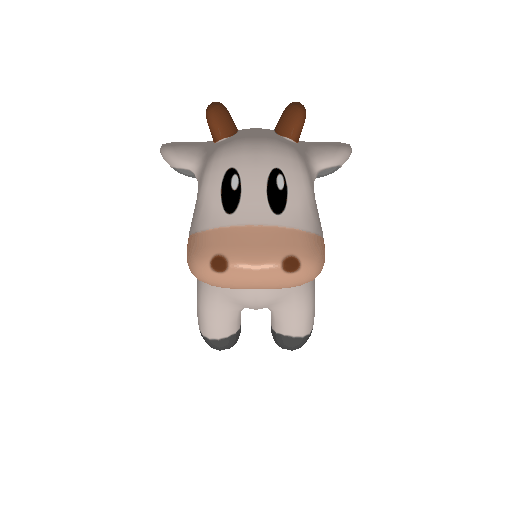

In [7]:
from IPython.display import Image
Image(filename='mesh_360_hardphongshader.gif')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

obj_filename = "./data/cow.obj"
mesh = load_objs_as_meshes([obj_filename], device=device)

color1 = [1.0, 0.0, 0.0]  
color2 = [0.0, 0.0, 1.0]  

colored_mesh = apply_color_gradient(mesh, color1, color2, device)

rendered_images = render_360_degree_mesh(
    colored_mesh,
    device=device,
    image_size=512,
    num_views=120,
    distance=2.7,
    elevation=30
)

save_gif(rendered_images, 'color_gradient_cow_360.gif', fps=30)

  0%|          | 0/120 [00:00<?, ?it/s]

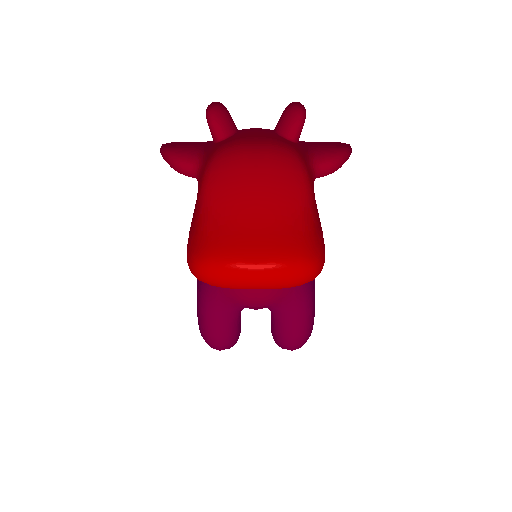

In [9]:
from IPython.display import Image
Image(filename='color_gradient_cow_360.gif')